![sutd](sutd.png)
## <center>50.040 Natural Language Processing, Summer 2020<center>
<center>**Homework 4**

<center>**Due 7 August 2020, 5pm** <center>

**Write your student ID and name**

ID:

Name:

Students whom you have discussed with (if any):

### Requirements:
- Use Python to complete this homework.
- Please list students with whom you have discussed (if any).
- Follow the honor code strictly.

In this homework, we'll implement ``IBM Model 1`` using the ``expectation–maximization (EM)`` algorithm. We need to estimate the  translation probabilities  $t(f|e)$ on a parallel corpus, where $e$ is a word from the English sentences and $f$ is a word from the corresponding foreign sentences. 

Note that there's a constraint for such probabilities:
$$\sum_f t(f|e)=1  \ \ \ (1)$$

**We'll use this constraint when initializing the translation probabilities in subsequent tasks.**

## Data
We'll use the English-French parallel corpus under the folder ``data/en-fr``, which contains a set of translation instances. As can be seen below each instance consists of an English-French sentence pair (note that we are translating from French into English, but as we discussed in class, when working on the translation model using IBM model 1, we are interested in generating French from English).



    Hop in.	Montez.
    Hug me.	Serre-moi dans tes bras !
    I left.	Je suis parti.

The dataset is obtained from [MXNET](http://data.mxnet.io/data/fra-eng.zip). Please run the provided code below to obtain the preprocessed English sentences and French sentences. Do not perform any further preprocessing. 


In [18]:
import seaborn as sns
import numpy as np
from time import time
from collections import Counter, defaultdict

from matplotlib import pyplot as plt
%matplotlib inline

# Part 1: Statistical Machine Translation \[25 points]

In [19]:
path = 'data/en-fr/en-fr.txt'
with open(path, 'r', encoding='utf8') as f:
    raw_text = f.read()

#Original code from 
#https://www.d2l.ai/chapter_recurrent-neural-networks
def preprocess_nmt(text):
    '''
    Arg:
        text: parallel text, string
    Return:
        out: preprocessed text, string
    '''
    text = text.replace('\u202f', ' ').replace('\xa0', ' ')
    no_space = lambda char, prev_char: (
        True if char in (',', '!', '.') and prev_char != ' ' else False)
    out = [' '+char if i > 0 and no_space(char, text[i-1]) else char
           for i, char in enumerate(text.lower())]
    out = ''.join(out)
    return out

def tokenize_nmt(text, num_examples = None):
    '''
    Args:
        text: parallel text, string
        num_examples: number of examples to be selected, int
    Returns:
        left: English sentences, list
        right: French sentences, list
    '''
    left, right = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples: break
        parts = line.split('\t')
        if len(parts) == 2:
            left.append(parts[0].split(' '))
            right.append(parts[1].split(' '))
    return left, right


In [20]:
#English sentences and corresponding French sentences
#Each sentence has been preprocessed and tokenized
text = preprocess_nmt(raw_text)
english_sents, french_sents = tokenize_nmt(text)

In [21]:
english_sents[:10], french_sents[:10]

([['go', '.'],
  ['hi', '.'],
  ['run', '!'],
  ['run', '!'],
  ['who?'],
  ['wow', '!'],
  ['fire', '!'],
  ['help', '!'],
  ['jump', '.'],
  ['stop', '!']],
 [['va', '!'],
  ['salut', '!'],
  ['cours', '!'],
  ['courez', '!'],
  ['qui', '?'],
  ['ça', 'alors', '!'],
  ['au', 'feu', '!'],
  ['à', "l'aide", '!'],
  ['saute', '.'],
  ['ça', 'suffit', '!']])


### Quesiton 1 (3 points)
1. Implement ``word_pairs_in_corpus`` which finds out all the possible word pairs $(e, f)$ that appear in all the instances of the English-French dataset ``english_sents``, ``french_sents``. Note that we need to pad each English sentence with the special token "NULL" at the beginning.
2. List down the 10 most frequent pairs. 
3. Count the number of unique pairs.

In [22]:
def word_pairs_in_corpus(en_sents, fr_sents):
    '''
    params:
        en_sents: list[list[str]]
        fr_sents: list[list[str]]
    return:
        align_counts: Dict()--- key: (english_word, french_word), value: counts of the word pair in the corpus
    '''
    align_counts = None
    # YOUR CODE HERE
#     eng = [['NULL'] + sent for sent in en_sents]
#     fr = fr_sents
    
    word_alignments = []
    for e, f in zip(en_sents, fr_sents):
        pairs = [(en_word, fr_word) for fr_word in f for en_word in e]
        word_alignments.extend(pairs)
    align_counts = Counter(word_alignments)
    # END OF YOUR CODE
    return align_counts

In [23]:
english_sents = [['NULL'] + sent for sent in english_sents]
align_counts = word_pairs_in_corpus(english_sents, french_sents)
align_counts.most_common(10), len(align_counts)

([(('.', '.'), 136734),
  (('NULL', '.'), 135221),
  (('i', '.'), 43189),
  (('NULL', 'je'), 39821),
  (('.', 'je'), 39096),
  (('NULL', 'de'), 35073),
  (('i', 'je'), 34415),
  (('to', '.'), 31647),
  (('.', 'de'), 30490),
  (('the', '.'), 29170)],
 1402126)

In [24]:
en_vocab = set([item[0] for item in align_counts.keys()])
fr_vocab = set([item[1] for item in align_counts.keys()])

In [25]:
len(en_vocab), len(fr_vocab)

(17430, 29741)

### Question 2 (2 points):

Implment the ``corpus_log_prob `` that computes the log probability of the corpus

In [26]:
# def log_prob(en, fr, t):
#     '''
#     logP(f|e)
#     Args:
#         en: English sentence, list
#         fr: French sentence, list
#         t: alignment parameters between English and French words, dictionary
#     Return:
#         obj: objective function, float
#     '''
#     logp = 0
#     for f_w in fr:
#         t_sum = 0
#         for e_w in en:
#             t_sum += t[(e_w, f_w)]
#         logp += np.log(t_sum)
#     #The source sentence has been padded with NULL
#     #logp += -1*np.log(len(src))*len(tgt)
#     return logp

def corpus_log_prob(en_sents, fr_sents, t):
    '''
    params:
        en_sents: list[list[str]]
        fr_sents: list[list[str]]
        t: Dict() --- contains translation probabilities
    return:
        logp: float --- log probability of the corpus
    '''
    logp = 0
    ### YOUR CODE HERE
    for en, fr in zip(en_sents, fr_sents):
        for f_w in fr:
            t_sum = 0
            for e_w in en:
                t_sum += t[(e_w, f_w)]
            logp += np.log(t_sum)
    # END OF YOUR CODE
    return logp

## Hard EM algorithm

### Question 3 (10 points)
Based on the word pairs obtained in Q1, implement ``Hard EM algorithm`` to calculate the  translation probabilities  $t(f|e)$ on the English-French corpus. Initialize the probabilities randomly under the constraint in Equation 1. Set the maximum iteration number as 10. 

It is possible that in the hard EM algorithm a word $\tilde{e}$ from an English sentence may not be aligned with any word from the corresponding French sentence. In this case, let us set the corresponding probabilities $t(f|\tilde{e})=\frac{1}{|V_f|}$ where $|V_f|$ is the size of the French vocabulary (in this case, the number of unique French words that ever appear in the training parallel corpus).

1. Implement ``init`` function which initializes the translation probability dictionary t.
2. Implement ``hard_EM`` function which runs one ``Expectation/Maximization`` iteration.
3. Run the training code

In [41]:
print(list(align_counts.keys())[:100])

[('NULL', 'va'), ('go', 'va'), ('.', 'va'), ('NULL', '!'), ('go', '!'), ('.', '!'), ('NULL', 'salut'), ('hi', 'salut'), ('.', 'salut'), ('hi', '!'), ('NULL', 'cours'), ('run', 'cours'), ('!', 'cours'), ('run', '!'), ('!', '!'), ('NULL', 'courez'), ('run', 'courez'), ('!', 'courez'), ('NULL', 'qui'), ('who?', 'qui'), ('NULL', '?'), ('who?', '?'), ('NULL', 'ça'), ('wow', 'ça'), ('!', 'ça'), ('NULL', 'alors'), ('wow', 'alors'), ('!', 'alors'), ('wow', '!'), ('NULL', 'au'), ('fire', 'au'), ('!', 'au'), ('NULL', 'feu'), ('fire', 'feu'), ('!', 'feu'), ('fire', '!'), ('NULL', 'à'), ('help', 'à'), ('!', 'à'), ('NULL', "l'aide"), ('help', "l'aide"), ('!', "l'aide"), ('help', '!'), ('NULL', 'saute'), ('jump', 'saute'), ('.', 'saute'), ('NULL', '.'), ('jump', '.'), ('.', '.'), ('stop', 'ça'), ('NULL', 'suffit'), ('stop', 'suffit'), ('!', 'suffit'), ('stop', '!'), ('NULL', 'stop'), ('stop', 'stop'), ('!', 'stop'), ('NULL', 'arrête-toi'), ('stop', 'arrête-toi'), ('!', 'arrête-toi'), ('NULL', 'atten

In [27]:
def init(align_counts):
    '''
    Use np.random.rand() to initialize translation probabilities t(f|e)
    params:
        align_counts: Dict() which we have computed in the first question.
    return:
        t: Dict(), key: (english_word, french_word), value: the initial probability t(f|e) 
    '''
    np.random.seed(5)
    t = dict()
    ### YOUR CODE HERE 
    t_total = dict()
    for key in align_counts.keys():
        prob = np.random.rand()
        t[key] = prob
        t_total[key[0]] = t_total.get(key[0], 0) + prob
    for key in t.keys():
        t[key] = t[key]/t_total[key[0]]
    ### END OF YOUR CODE
    return t

In [28]:
def hard_EM(en_sents, fr_sents, fr_vocab, t):
    '''
    One 'Expectation', 'Maximization' iteration.
    params:
        en_sents: List[List[str]]
        fr_sents: List[List[str]]
        fr_vocab: int --- size of the French vocab
        t: Dict() --- dictionary from last iteration
        
    return:
        t: updated parameters, dictionary --- t
    '''
    new_t = t
    ### YOUR CODE HERE
    #Initialize 
    count_pair = defaultdict(int) #alignment
    count_eng = defaultdict(int) #french
        
    #Compute normalization
    for en, fr in zip(en_sents, fr_sents):
        align_words = []
        for f_w in fr:
            max_value = -1
            best_align_word = None
            for i, e_w in enumerate(en):
                if t[(e_w, f_w)] > max_value:
                    max_value = t[(e_w, f_w)]
                    best_align_word = e_w
            align_words.append(best_align_word)
        pairs = list(zip(align_words, fr))
        
        for pair in pairs:
            count_pair[pair] += 1
            count_eng[pair[0]] += 1
    
    for k in t.keys():
        new_t[k] = float(count_pair[k]) / count_eng[k[0]] if count_eng[k[0]] != 0 else 1.0/len(fr_vocab)
    ### END OF YOUR CODE
    
    return new_t

In [29]:
############################################################
# Randomly initialized the probabilities under the contraint
############################################################
hard_t = init(align_counts)
    
##################
# Hard EM training
##################
iteration = 0
while iteration < 10:
    
    logp = corpus_log_prob(english_sents, french_sents, hard_t)    
    hard_t = hard_EM(english_sents, french_sents, fr_vocab, hard_t)  
    print('Objective Function:', round(logp, 5))
    iteration += 1

Objective Function: -5660433.47618
Objective Function: -3015603.70445
Objective Function: -2321536.03466
Objective Function: -2197760.14326
Objective Function: -2148977.70936
Objective Function: -2104673.87534
Objective Function: -2070829.62165
Objective Function: -2065460.32851
Objective Function: -2064212.91853
Objective Function: -2062910.94064


In [30]:
# np.random.seed(5)
# t, t_total = dict(), dict()
# #  Randomly initialized the probabilities under the contraint
# for key in word_align:
#     prob = np.random.rand()
#     t[key] = prob
#     t_total[key[0]] = t_total.get(key[0], 0) + prob
# for key in t.keys():
#     t[key] = t[key]/t_total[key[0]]
# ############################################################
    
# i = 0
# while i < 10:
    
#     logp = corpus_log_prob(eng_sents, french_sents, t)    
#     t= hard_EM(eng_sents, fr_sents, t)  
#     print('Objective Function:', round(logp, 5))
#     i += 1

### Visualization
Using 2D-heatmap, visualize the word alignment (namely $t(f|e)$) for each of the instances below:

    NULL tom loves chocolate .   tom adore le chocolat .    
    NULL it was a very exciting game .   c'était un jeu vraiment très excitant .  

In [31]:
# def calculate_alignment(en, fr, t):
#     '''
#     params:
#         en: List[str] --- english sentence
#         fr: List[str] --- french sentence
#         t: Dict() --- translation probability
#     return:
#         alignment: Numpy.array --- store the 
#     '''
#     alignments = np.zeros([len(fr), len(en)])
    
#     for i in range(len(fr)):
#         for j in range(len(en)):
#             alignments[i, j] = t[(en[j], fr[i])]
#     return alignments

In [32]:
def visualize_alignment(en, fr, t):
    '''
    Visualize the alignments of an instance
    '''
    alignments = np.zeros([len(fr), len(en)])
    for i in range(len(fr)):
        for j in range(len(en)):
            alignments[i, j] = t[(en[j], fr[i])]
    sns.heatmap(alignments, cmap='PuBuGn', annot=True)
    _, _ = plt.yticks(np.arange(len(fr))+0.5, fr, rotation=0, fontsize=10)
    _, _ = plt.xticks(np.arange(len(en))+0.5, en, rotation=30, fontsize=10)

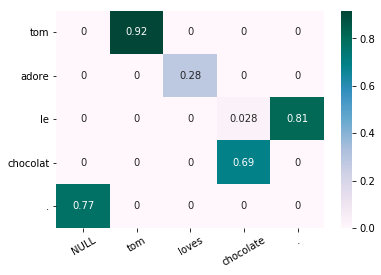

In [33]:
en = "NULL tom loves chocolate .".split()
fr = "tom adore le chocolat .".split()
visualize_alignment(en, fr, hard_t)

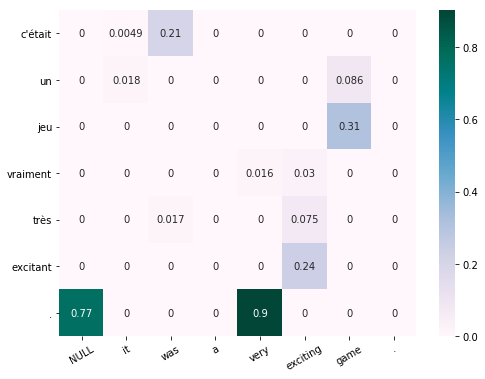

In [36]:
plt.figure(figsize=(8, 6))
en = "NULL it was a very exciting game .".split()
fr = "c'était un jeu vraiment très excitant .".split()
visualize_alignment(en, fr, hard_t)

## Soft EM algorithm

### Question 4 (10 points)
Implement a soft EM algorithm with the translation probabilities $t(f|e)$ randomly initialized under the constraint in Equation 1. Let us use the objective function defined in the slides to check whether our algorithm can converge as expected. The objective of the entire training set is denoted as: 

$$\sum_{k} \sum_{i=1}^{m_k}log(\sum_{j=0}^{n_k}t(f^k_i\mid e^k_j)) \ \ \ (2)$$
where  $m_k$ is the length of the French sentence, $n_k$ is the length of the English sentence in the $k$-th instance.

Implement ``soft_EM`` function.

In [37]:
def soft_EM(en_sents, fr_sents, t):
    '''
    params:
        en_sents: English sentences, list
        fr_sents: foreign sentences, list
    return:
        t: updated parameters, dictionary
    '''
    t = t
    ### YOUR CODE HERE
    #Initialize 
    count_pair = defaultdict(int) #alignment
    count_eng = defaultdict(int) #english

    #Compute normalization
    for en, fr in zip(en_sents, fr_sents):
        t_sum = dict()
        for f_w in fr:
            for e_w in en:
                #Note that one word may appear twice or more in a sentence
                t_sum[f_w] = t_sum.get(f_w, 0) + t[(e_w, f_w)]

        #Collect counts
        for f_w in fr:
            for e_w in en:
                count_pair[(e_w, f_w)] +=  t[(e_w, f_w)]/t_sum[f_w]
                count_eng[e_w] += t[(e_w, f_w)]/t_sum[f_w]
                
    #estimate probabilities
    for k in t.keys():
        t[k] = count_pair[k]/count_eng[k[0]]
    ### END OF YOUR CODE
    return t

Let us check the algorithm first using the objective value.

In [38]:
############################################################
# Randomly initialized the probabilities under the contraint
############################################################
soft_t = init(align_counts)
    
##################
# Hard EM training
##################
iteration = 0
while iteration < 15:
    
    logp = corpus_log_prob(english_sents, french_sents, soft_t)    
    soft_t = soft_EM(english_sents, french_sents, soft_t)  
    print('Objective Function:', round(logp, 5))
    iteration += 1

Objective Function: -5660433.47618
Objective Function: -2764731.0147
Objective Function: -1962145.54812
Objective Function: -1728542.6729
Objective Function: -1643955.49389
Objective Function: -1605980.78305
Objective Function: -1587001.61434
Objective Function: -1576553.44101
Objective Function: -1570284.63925
Objective Function: -1566266.82773
Objective Function: -1563555.38801
Objective Function: -1561644.60503
Objective Function: -1560263.6266
Objective Function: -1559237.93027
Objective Function: -1558454.96837


### Visualization

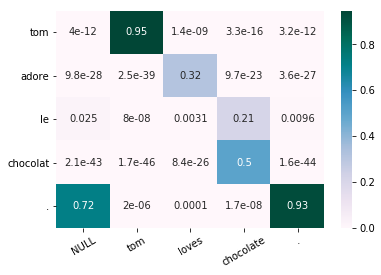

In [39]:
en = "NULL tom loves chocolate .".split()
fr = "tom adore le chocolat .".split()
visualize_alignment(en, fr, soft_t)

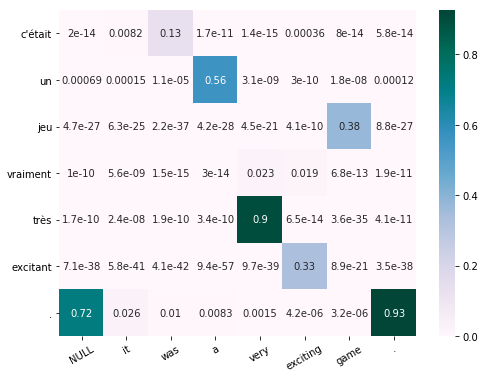

In [40]:
plt.figure(figsize=(8,6))
en = "NULL it was a very exciting game .".split()
fr = "c'était un jeu vraiment très excitant .".split()
visualize_alignment(en, fr, soft_t)